# SAM Analysis
Designed to calculate and plot the SAM. Link to [Data analysis](#Data-Analysis).

#### Dask

<br>

#### Choices for data

In [74]:
#Experiment data for analysis
dataVariableId = 'psl'
dataSourceId = "UKESM1-0-LL"
experimentId = "historical"
tableId = "Amon"
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

externalSAMFileName = "SAMIndex.txt"

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [75]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from scipy import signal
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading the ESM data</b>

In [76]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.source_id.eq(dataSourceId) & df.table_id.eq(tableId) & df.experiment_id.eq(experimentId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No ESM3 data sets opened")
    
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets
print("Data sets successfully merged")

dfESMLat = fileSet.psl.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

3 ESM3 data sets opened
Data sets successfully merged
ESM data sucessfully loaded.


<br>
<b>Loading the ocean mask</b>

In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded into oceanMask")

Mask Loaded into oceanMask


<br>
<b>Loading external SAM Index</b>

In [7]:
externalSAMIndex = np.loadtxt("SAMIndex.txt", skiprows=1, max_rows=64)
externalSAMIndexYear = np.transpose(externalSAMIndex)[0]
externalSAMIndexSort = np.empty(shape=(0,2))
for i in range(len(externalSAMIndexYear)):
    for j in range(1,13):
        externalSAMIndexSort = np.append(externalSAMIndexSort, [[np.datetime64(str(int(externalSAMIndexYear[i]))+"-"+f"{j:02d}", "M"), externalSAMIndex[i][j]]], axis=0)
externalSAMIndexSort = np.transpose(externalSAMIndexSort)
print("External SAM index data in "+externalSAMFileName+" loaded into externalSAMIndexSort.")

External SAM index data in SAMIndex.txt loaded into externalSAMIndexSort.


<br>

#### SAM pressure calculations

In [8]:
if True:
    normalisationData = dfESMLat.sel(time=slice('1971-01','2000-12'))
    normalisationDataP40 = normalisationData.sel(lat=-40, method="nearest")
    selLat40 = normalisationDataP40["lat"].values
    normalisationDataP65 = normalisationData.sel(lat=-65, method="nearest")
    selLat65 = normalisationDataP65["lat"].values

    normalisationDataP40MLon = normalisationDataP40.mean(["lon"], keep_attrs=True)
    normalisationDataP65MLon = normalisationDataP65.mean(["lon"], keep_attrs=True)
    normalisationDataP40MLonG = normalisationDataP40MLon.groupby("time.month")
    normalisationDataP65MLonG = normalisationDataP65MLon.groupby("time.month")
    P40m = normalisationDataP40MLonG.mean(["time"], keep_attrs=True).values
    P65m = normalisationDataP65MLonG.mean(["time"], keep_attrs=True).values

    normalisationDataP40G = normalisationDataP40.groupby("time.month")
    P40std = normalisationDataP40MLonG.std(["time"], keep_attrs=True).values #
    normalisationDataP65G = normalisationDataP65.groupby("time.month")
    P65std = normalisationDataP65MLonG.std(["time"], keep_attrs=True).values #
else:
    normalisationData = dfESMLat.sel(time=slice('1971-01','2000-12'))
    normalisationDataP40 = normalisationData.sel(lat=slice(-41,-39))
    normalisationDataP40M = normalisationDataP40.mean("lat", keep_attrs=True)
    normalisationDataP65 = normalisationData.sel(lat=slice(-66,-64))
    normalisationDataP65M = normalisationDataP65.mean("lat", keep_attrs=True)

    normalisationDataP40MLon = normalisationDataP40M.mean(["lon"], keep_attrs=True)
    normalisationDataP65MLon = normalisationDataP65M.mean(["lon"], keep_attrs=True)
    normalisationDataP40MLonG = normalisationDataP40MLon.groupby("time.month")
    normalisationDataP65MLonG = normalisationDataP65MLon.groupby("time.month")
    P40m = normalisationDataP40MLonG.mean(["time"], keep_attrs=True).values
    P65m = normalisationDataP65MLonG.mean(["time"], keep_attrs=True).values

    normalisationDataP40G = normalisationDataP40.groupby("time.month")
    P40std = normalisationDataP40G.std(["lat","lon","time"], keep_attrs=True).values
    normalisationDataP65G = normalisationDataP65.groupby("time.month")
    P65std = normalisationDataP65G.std(["lat","lon","time"], keep_attrs=True).values
print("Normalisation data calculated.")

Normalisation data calculated.


In [7]:
# DISPLAY DATA?

<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>externalSAMSearch - returns externalSAMIndexSort between two dates.
<li>SAMCalculateRaw - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±1°) for an input data array, not normalised .
<li>SAMCalculateNorm - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±1°) for an input data array, normalised using second input data array.
</ul>

In [9]:
def butter_lowpass(data,cut,order=4,sample_freq=1) :
    nyq = 0.5*sample_freq
    pass_freq =1./cut/nyq
    sos=signal.butter(order, pass_freq, 'low', output='sos')
    filt=signal.sosfiltfilt(sos,data)
    return filt


def externalSAMSearch(startDate, endDate):
    '''Performs np searching across externalSAMIndexSort for start-end date data, returns 2 x n np.array containing [dates][data]'''
    x, startIndex = np.where(externalSAMIndexSort == np.datetime64(startDate, 'M'))
    x, endIndex = np.where(externalSAMIndexSort == np.datetime64(endDate, 'M'))
    dateArray = externalSAMIndexSort[0][startIndex[0] : endIndex[0] + 1]
    dataArray = externalSAMIndexSort[1][startIndex[0] : endIndex[0] + 1]
    externalSAMSearch = np.append([dateArray], [dataArray], axis=0)
    return externalSAMSearch


def SAMCalculateNorm(dataArray, runId):
    '''Calculates the SAM index using P40m, P65m, P40std and P65std. Returns SAM index np array.'''
    timeArray = dataArray["time"].values
    startTimeY = timeArray[0].astype('datetime64[Y]').astype(int) + 1970
    endTimeY = timeArray[-1].astype('datetime64[Y]').astype(int) + 1970
    startTimeM = timeArray[0].astype('datetime64[M]').astype(int) % 12 + 1
    endTimeM = timeArray[-1].astype('datetime64[M]').astype(int) % 12 + 1

    P40 = dataArray.sel(lat=slice(-41, -39))
    P65 = dataArray.sel(lat=slice(-66, -64))

    P40zArray = np.empty(shape=0)
    P65zArray = np.empty(shape=0)
    if startTimeM > 1: #Part start year z transform
        P40YearPartS = P40.sel(time = str(startTimeY))
        P40YearPartS = P40YearPartS.mean(dim=["lat", "lon"])
        P40YearPartS = P40YearPartS.reset_coords(drop=True)
        P40zYearPartS = ((P40YearPartS-P40m[startTimeM-1:])/P40std[startTimeM-1:]).values
        P40zArray = np.append(P40zArray, P40zYearPartS)

        P65YearPartS = P65.sel(time = str(startTimeY))
        P65YearPartS = P65YearPartS.mean(dim=["lat", "lon"])
        P65YearPartS = P65YearPartS.reset_coords(drop=True)
        P65zYearPartS = ((P65YearPartS-P65m[startTimeM-1:])/P65std[startTimeM-1:]).values
        P65zArray = np.append(P65zArray, P65zYearPartS)
        startTimeY += 1  

    P40zYearPartE = np.empty(0)
    P65zYearPartE = np.empty(0)
    if endTimeM < 12: #Part end year z transform
        P40YearPartE = P40.sel(time = str(endTimeY))
        P40YearPartE = P40YearPartE.mean(dim=["lat", "lon"])
        P40YearPartE = P40YearPartE.reset_coords(drop=True)
        P40zYearPartE = ((P40YearPartE-P40m[:endTimeM-12])/P40std[:endTimeM-12]).values

        P65YearPartE = P65.sel(time = str(endTimeY))
        P65YearPartE = P65YearPartE.mean(dim=["lat", "lon"])
        P65YearPartE = P65YearPartE.reset_coords(drop=True)
        P65zYearPartE = ((P65YearPartE-P65m[:endTimeM-12])/P65std[:endTimeM-12]).values
        endTimeY -= 1  

    if startTimeY <= endTimeY: #Full year z transform
        for i in range(startTimeY, endTimeY + 1):
            P40Year = P40.sel(time = str(i))
            P40Year = P40Year.mean(dim=["lat", "lon"])
            P40Year = P40Year.reset_coords(drop=True)
            P40zYear = ((P40Year-P40m[runId])/P40std[runId]).values
            P40zArray = np.append(P40zArray, P40zYear)

            P65Year = P65.sel(time = str(i))
            P65Year = P65Year.mean(dim=["lat", "lon"])
            P65Year = P65Year.reset_coords(drop=True)
            P65zYear = ((P65Year-P65m[runId])/P65std[runId]).values
            P65zArray = np.append(P65zArray, P65zYear)

    P40zArray = np.append(P40zArray, P40zYearPartE) #Appends End year
    P65zArray = np.append(P65zArray, P65zYearPartE) #Appends End year
    
    SAMArray = P40zArray - P65zArray
    SAMArray = np.round(SAMArray, 2)
    
    try:
        intRunId = runId.values
    except:
        intRunId = runId
    
    indexName = "SAM_Index_"+str(intRunId)
    exportSAMData = {"time":timeArray, indexName:SAMArray}
    exportSAMDF = pd.DataFrame(exportSAMData, columns=["time",indexName])
    return exportSAMDF

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li> mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
<li> timePlot -  plots the SAM index in the input data array over time.
<li> timePlotStd - plots the SAM index for a 12 month period (starting January) with error bars.
<li> timePlotYear - plots the SAM index for a 12 month period (starting January) without error bars. Compatible with timePlotStd.
<li> timePlotDecade - plots the SAM index for an input data array over a decade period. Start date is dispalyed as 2001-01.
</ul>

In [25]:
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
lineType = ["-.", "--", ":"]

def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map.'''
    latMax = max(dataSet["lat"].values)
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    plt.plot(np.arange(0,361,1),np.ones(361)*latMax+0.5, transform=ccrs.PlateCarree(), color="Black")
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))


def SAMLatPlot(plotNo):
    '''Plots SAM index latitudes on a map, requires selLat40 and selLat65'''
    plt.figure(plotNo, figsize=(7,7))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    plt.plot(np.arange(0,361,1),np.ones(361)*selLat40, transform=ccrs.PlateCarree(), color="Black")
    plt.plot(np.arange(0,361,1),np.ones(361)*selLat65, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Selected latitudes for SAM index calculation")    
    
    
def timePlot(dataArray, runId, label, title, plotNo):
    '''Displays SAM index over time for any given range.'''
    plt.figure(plotNo, figsize = (20,10))
    indexName = "SAM_Index_"+str(runId)
    plt.plot(dataArray["time"], dataArray[indexName],label = str(label))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axhline(0, color="Black", lw=0.5)
    plt.legend(loc='upper right')
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotStd(dataSetMean, dataSetError, title, plotNo):
    '''Displays SAM index with standard deviations over a 12 month period.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.errorbar(months, dataSetMean.values, yerr=dataSetError.values, label = dataSetMean.name, capsize=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotYear(dataArray, title, plotNo):
    '''Displays SAM index for a 12 month period starting in January. Compatible with timePlotStd.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.plot(months, dataArray.values, label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))

def timePlotDecade(dataArray, runId, label, title, plotNo):
    '''Displays SAM index over a decade.'''
    timeAxis = np.arange(np.datetime64("2001-01"), np.datetime64("2011-01"), np.timedelta64(1, 'M'), dtype='datetime64[M]')
    indexName = "SAM_Index_"+str(runId)
    plt.figure(plotNo, figsize = (20,10))
    plt.plot(timeAxis, dataArray[indexName], label = str(label))
    plt.axhline(0, color="Black", lw=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel("SAM Index")
    plt.xlabel("Time")
    plt.title(str(title))
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Plotting the mask

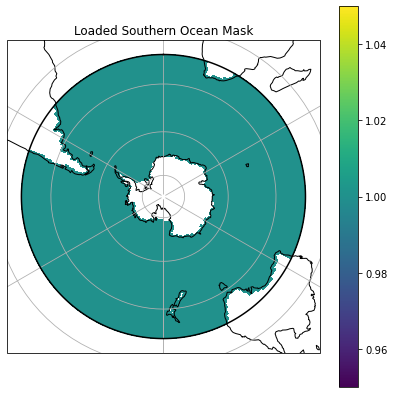

In [10]:
mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)

<br>

#### Latitudes Visualised

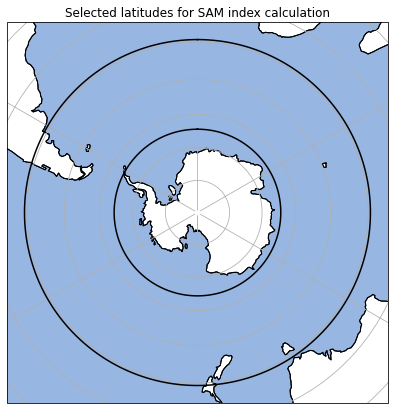

In [11]:
SAMLatPlot(1)
plt.show()

<br>

#### Data Visualisation

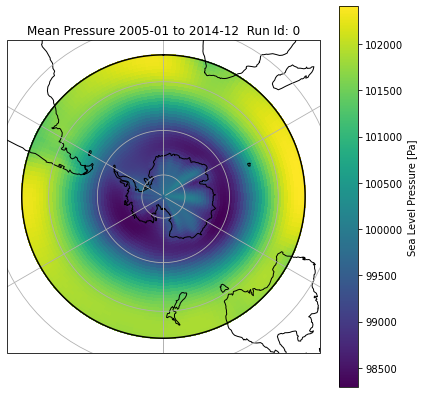

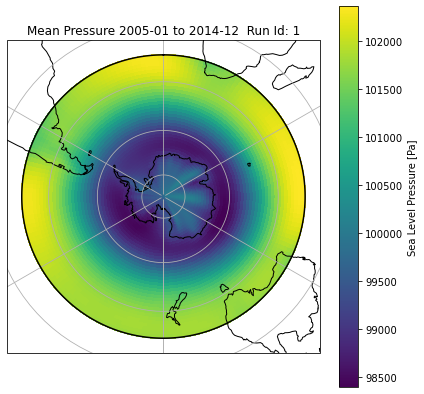

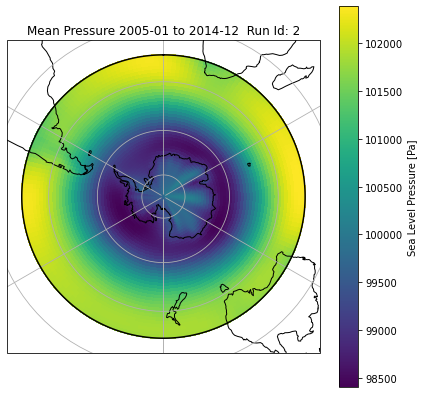

In [12]:
for i in dfESMLat["RunId"].values:
    lastDecadeData = dfESMLat.sel(time=slice("2005-01", "2014-12"),RunId = i)
    lastDecadeDataMean = lastDecadeData.mean("time", keep_attrs=True)
    mapPlot(lastDecadeDataMean, "Mean Pressure 2005-01 to 2014-12  Run Id: "+str(i), i)
plt.show()

<br>

#### Data Analysis

<br>
<b>SAM index 2005 - 2014</b>

In [11]:
startDate, endDate = "2005-01","2014-12"
extSAM2005_14 = externalSAMSearch(startDate, endDate)
runID = 0
SAM2005_14_data = dfESMLat.sel(time=slice(startDate, endDate), RunId=runID)
SAM2005_14 = SAMCalculateNorm(SAM2005_14_data, runID)
print("External and ESM (RunID: "+str(runID)+") SAM calculated for "+startDate+" - "+endDate+".")

External and ESM (RunID: 0) SAM calculated for 2005-01 - 2014-12.


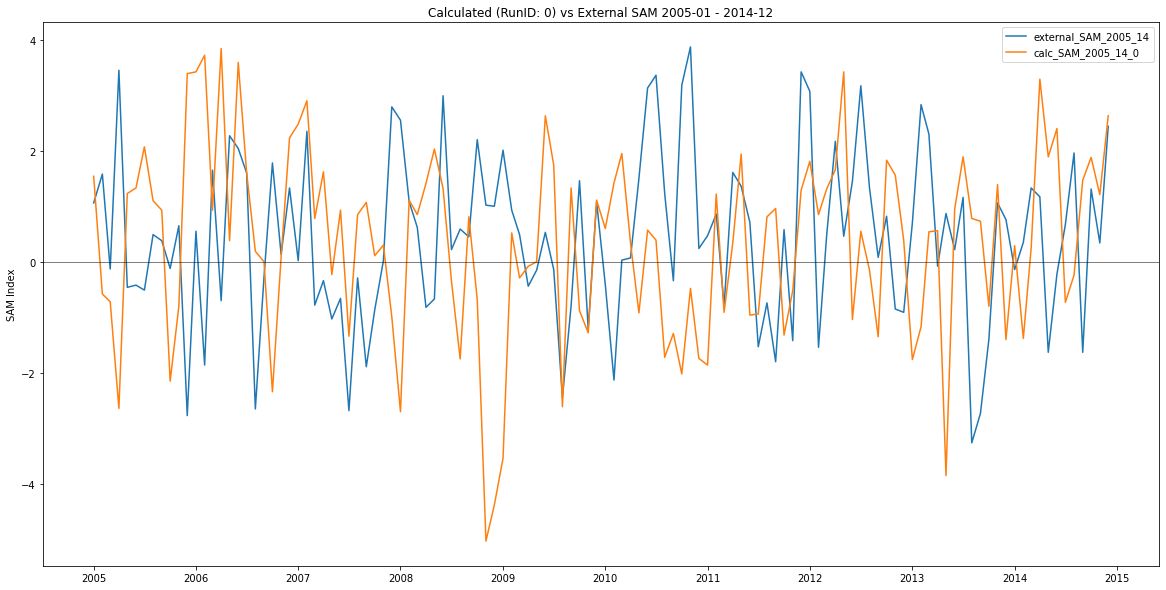

In [26]:
plt.figure(1, figsize=(20,10))
plt.plot(extSAM2005_14[0], extSAM2005_14[1], label="external_SAM_2005_14")
timePlot(SAM2005_14, 0, "calc_SAM_2005_14_0", "Calculated (RunID: "+str(runID)+") vs External SAM "+startDate+" - "+endDate, 1)
plt.show()

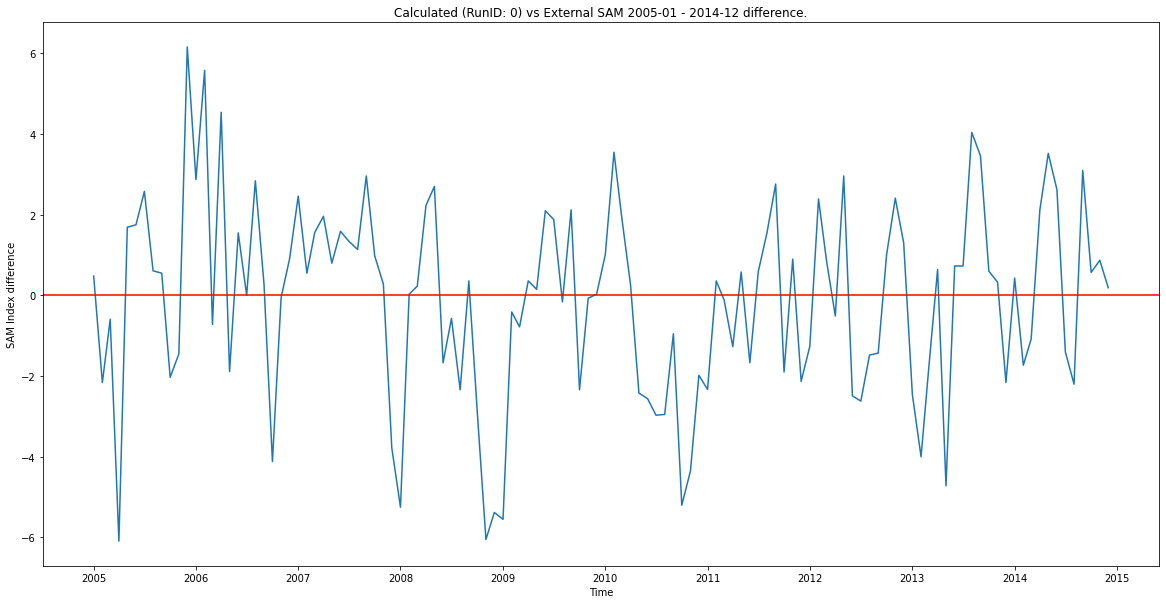

In [19]:
SAMDiff = SAM2005_14["SAM_Index_0"] - extSAM2005_14[1]
plt.figure(1, figsize=(20,10))
plt.plot(extSAM2005_14[0], SAMDiff, label="external_SAM_2005_14")
plt.axhline(0, color="Red")
plt.title("Calculated (RunID: "+str(runID)+") vs External SAM "+startDate+" - "+endDate+" difference.")
plt.ylabel("SAM Index difference")
plt.xlabel("Time")
plt.show()

<br>
<b>Decade SAM Index comparison</b><br>
As different decades are being compared the time axis uses 2001 to represent the starting date.

In [20]:
runIdDec = 0
SAM1971_80 = SAMCalculateNorm(dfESMLat.sel(time=slice("1971-01","1980-12"), RunId=runIdDec), runIdDec)
SAM1991_00 = SAMCalculateNorm(dfESMLat.sel(time=slice("1991-01","2000-12"), RunId=runIdDec), runIdDec)
print("Decade normalised SAMs calculated (1971-80, 1991-2000) (RunID: "+str(runIdDec)+").")

Decade normalised SAMs calculated (1971-80, 1991-2000) (RunID: 0).


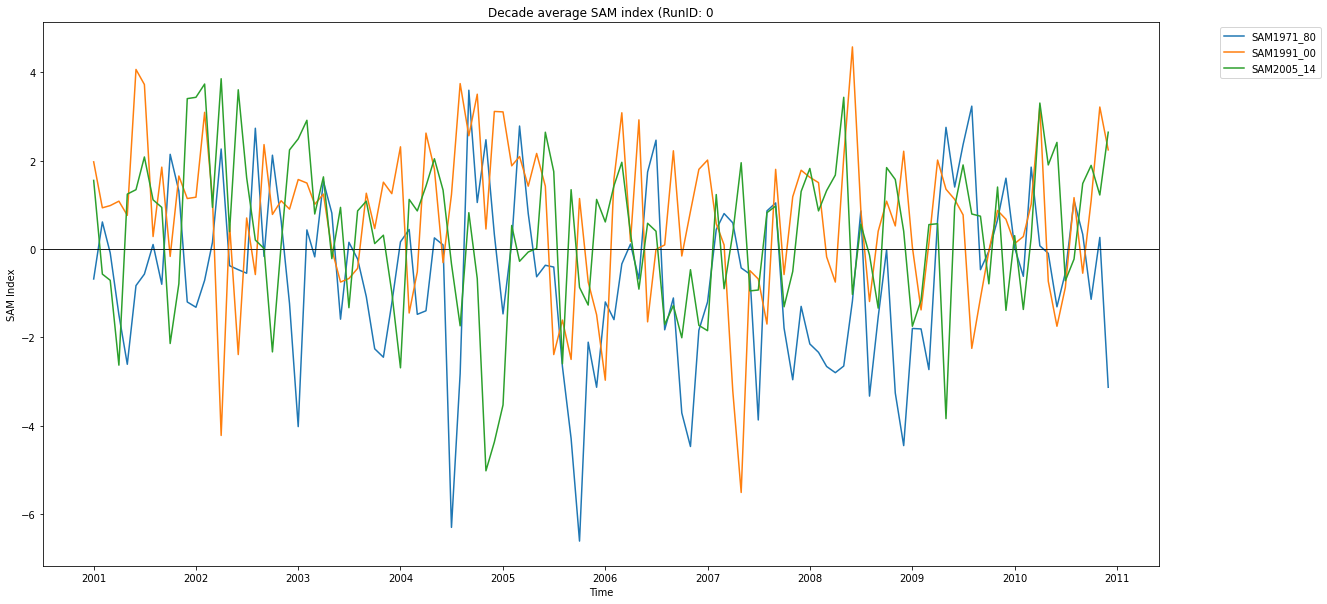

In [27]:
timePlotDecade(SAM1971_80, runIdDec, "SAM1971_80", "Decade average SAM index (RunID: "+str(runIdDec)+"", 1)
timePlotDecade(SAM1991_00, runIdDec, "SAM1991_00", "Decade average SAM index (RunID: "+str(runIdDec)+"", 1)
timePlotDecade(SAM2005_14, runIdDec, "SAM2005_14", "Decade average SAM index (RunID: "+str(runIdDec)+"", 1)
plt.show()

<br>
<b>SAM trend for ESM time period</b><br>

In [28]:
startDate, endDate = "1850-01","2014-12"

SAM1850_14DF = pd.DataFrame({'time' : dfESMLat.time.sel(time=slice(startDate, endDate)).values})
for i in dfESMLat["RunId"]:
    SAM1850_14Part_data = dfESMLat.sel(time=slice(startDate, endDate), RunId=i)
    SAM1850_14Part = SAMCalculateNorm(SAM1850_14Part_data, i)
    SAM1850_14DF = SAM1850_14DF.merge(SAM1850_14Part, left_on="time", right_on="time")

print("External and internal SAM calculated for "+startDate+" - "+endDate+".")

External and internal SAM calculated for 1850-01 - 2014-12.


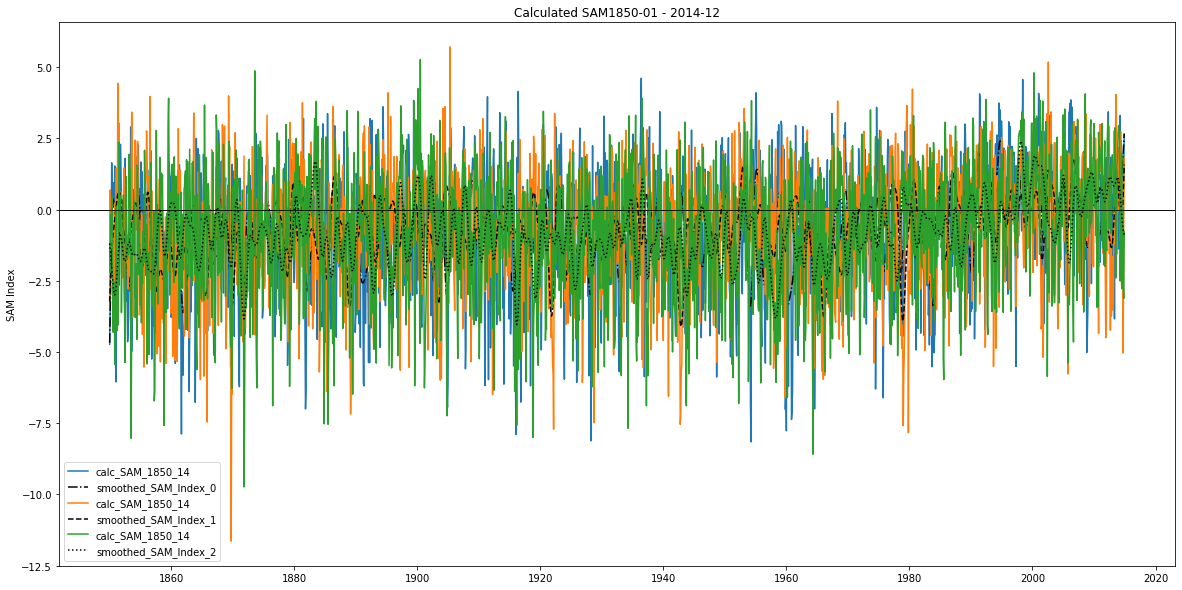

In [33]:
smooth18SAM1850_14Arr = np.empty(shape=(0,len(SAM1850_14DF["time"])))
for i in range(fileCount):
    indexName = "SAM_Index_"+str(i)
    smooth18SAM1850_14 = butter_lowpass(SAM1850_14DF[indexName], 18)
    smooth18SAM1850_14Arr = np.append(smooth18SAM1850_14Arr, [smooth18SAM1850_14], axis=0)
    #SAM1850_14Single = pd.DataFrame(SAM1850_14DF, columns=["time", indexName])
    #SAM1850_14Single = SAM1850_14Single.rename(columns={indexName:"SAM_Index"})
    timePlot(SAM1850_14DF, i, "calc_SAM_1850_14", "Calculated SAM"+startDate+" - "+endDate, 1)
    plt.plot(SAM1850_14DF["time"], smooth18SAM1850_14Arr[i%3], color="Black", ls=lineType[i], label="smoothed_"+indexName)
plt.axhline(0, color="Black", lw=0.5)
plt.legend()
plt.show()

<br>
<b>SAM smoothing</b>

In [34]:
startDate, endDate = "1957-01","2014-12"
extSAM1957_14 = externalSAMSearch(startDate, endDate)

SAM1957_14DF = pd.DataFrame({'time' : dfESMLat.time.sel(time=slice(startDate, endDate)).values})
for i in range(fileCount):
    SAM1957_14_data = dfESMLat.sel(time=slice(startDate, endDate), RunId=i)
    SAM1957_14Part = SAMCalculateNorm(SAM1957_14_data, i)
    SAM1957_14DF = SAM1957_14DF.merge(SAM1957_14Part, left_on="time", right_on="time")
    
print("External and internal SAM calculated for "+startDate+" - "+endDate+".")

External and internal SAM calculated for 1957-01 - 2014-12.


In [43]:
smooth18SAM1957_14Arr = np.empty(shape=(0,len(SAM1957_14DF["time"])))
smooth24SAM1957_14Arr = np.empty(shape=(0,len(SAM1957_14DF["time"])))
smooth120SAM1957_14Arr = np.empty(shape=(0,len(SAM1957_14DF["time"])))

smooth18extSAM1957_14 = butter_lowpass(extSAM1957_14[1], 18)
for i in range(fileCount):
    indexName = "SAM_Index_"+str(i)
    smooth18SAM1957_14 = butter_lowpass(SAM1957_14DF[indexName], 18)
    smooth18SAM1957_14Arr = np.append(smooth18SAM1957_14Arr, [smooth18SAM1957_14], axis=0)


smooth24extSAM1957_14 = butter_lowpass(extSAM1957_14[1], 24)
for i in range(fileCount):
    indexName = "SAM_Index_"+str(i)
    smooth24SAM1957_14 = butter_lowpass(SAM1957_14DF[indexName], 24)
    smooth24SAM1957_14Arr = np.append(smooth24SAM1957_14Arr, [smooth24SAM1957_14], axis=0)

smooth120extSAM1957_14 = butter_lowpass(extSAM1957_14[1], 120)
for i in range(fileCount):
    indexName = "SAM_Index_"+str(i)
    smooth120SAM1957_14 = butter_lowpass(SAM1957_14DF[indexName], 120)
    smooth120SAM1957_14Arr = np.append(smooth120SAM1957_14Arr, [smooth120SAM1957_14], axis=0)
    
print("Smoothing calculated for SAM Index.")

Smoothing calculated for SAM Index.


1

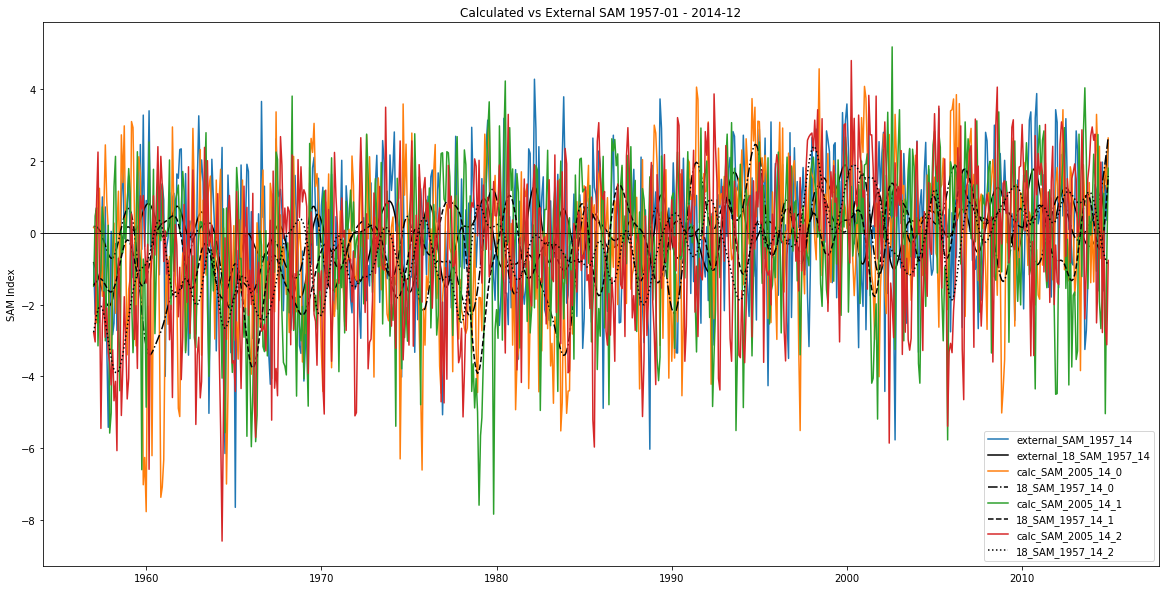

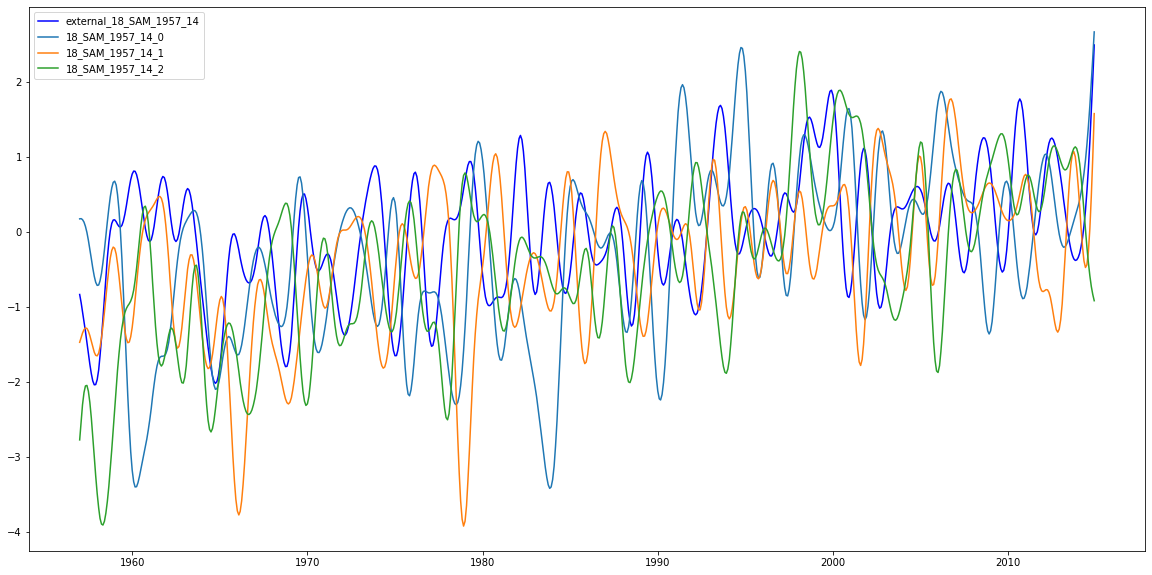

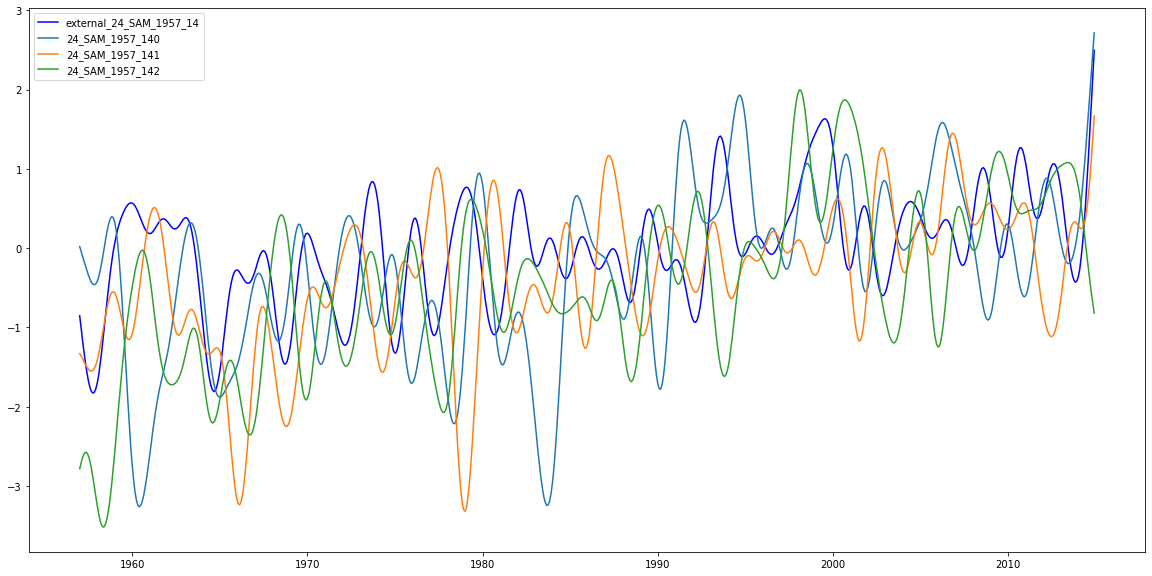

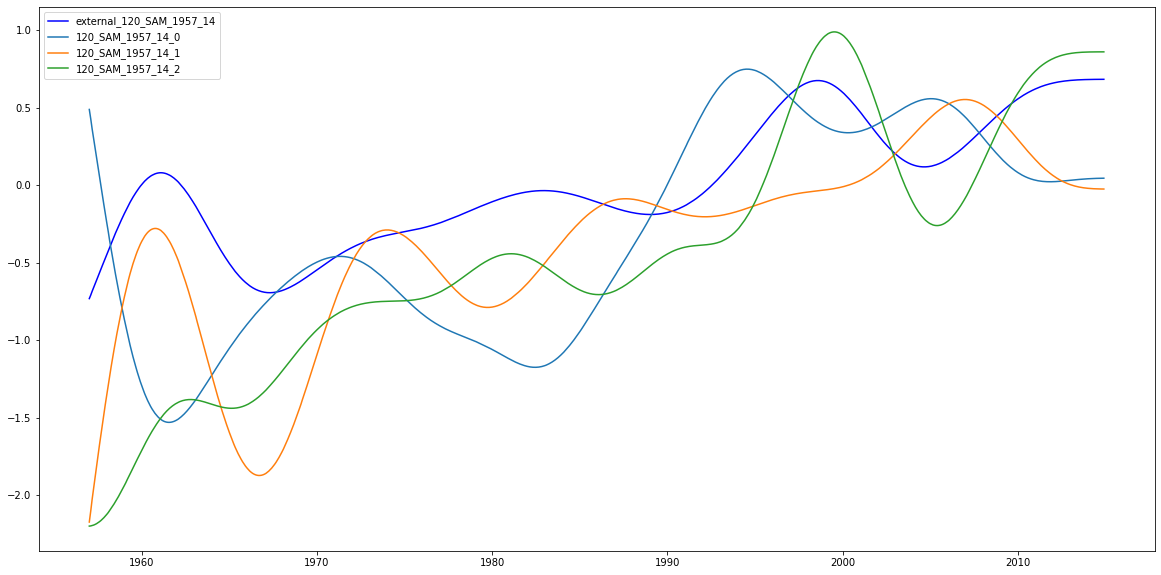

In [44]:
plt.figure(1, figsize=(20,10))
plt.plot(extSAM1957_14[0], extSAM1957_14[1], label="external_SAM_1957_14")
plt.plot(SAM1957_14DF["time"], smooth18extSAM1957_14, color="Black", label="external_18_SAM_1957_14")
for i in range(fileCount):
    timePlot(SAM1957_14DF, i, "calc_SAM_2005_14_"+str(i), "Calculated vs External SAM "+startDate+" - "+endDate, 1)
    plt.plot(SAM1957_14DF["time"], smooth18SAM1957_14Arr[i], color="Black", ls=lineType[i%3], label="18_SAM_1957_14_"+str(i))
plt.legend()

plt.figure(2, figsize=(20,10))
plt.plot(SAM1957_14DF["time"], smooth18extSAM1957_14, color="Blue", label="external_18_SAM_1957_14")
for i in range(fileCount):
    plt.plot(SAM1957_14DF["time"], smooth18SAM1957_14Arr[i], label="18_SAM_1957_14_"+str(i))
plt.legend()


plt.figure(3, figsize=(20,10))
plt.plot(SAM1957_14DF["time"], smooth24extSAM1957_14, color="Blue", label="external_24_SAM_1957_14")
for i in range(fileCount):
    plt.plot(SAM1957_14DF["time"], smooth24SAM1957_14Arr[i], label="24_SAM_1957_14"+str(i))
plt.legend()

plt.figure(4, figsize=(20,10))
plt.plot(SAM1957_14DF["time"], smooth120extSAM1957_14, color="Blue", label="external_120_SAM_1957_14")
for i in range(fileCount):
    plt.plot(SAM1957_14DF["time"], smooth120SAM1957_14Arr[i], label="120_SAM_1957_14_"+str(i))
plt.legend()

plt.show()

In [47]:
for i in range(fileCount):
    print(smooth24SAM1957_14Arr[i]-smooth24SAM1957_14Arr[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
x =